In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from astropy.table import QTable
from astropy import units as u
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy.timeseries import TimeSeries

mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18

%config InlineBackend.figure_format = 'retina'

np.random.seed(42)

In [2]:
# Load PHEMU occultation lightcurves where Europa occults Io
import os
path = "../data/phemu_catalog/mutual/2009/"

lc_occ = []
lc_ec = []
names_occ = ["2o1"]

for file in os.listdir(path):
    if any(x in file for x in names_occ):
        # Grab date
        y, m, d = file[1:5], file[5:7], file[7:9]
        date_mjd = Time(f'{y}-{m}-{d}', format='isot', scale='utc').to_value('mjd')
        
        lc = np.genfromtxt(os.path.join(path, file))
        times_mjd = date_mjd + lc[:, 0]/(60*24)

        timeseries = TimeSeries(time=Time(times_mjd, format='mjd'))
        timeseries['flux'] = lc[:, 1]
        lc_occ.append(timeseries)

'2009-12-04 08:53:00.931'

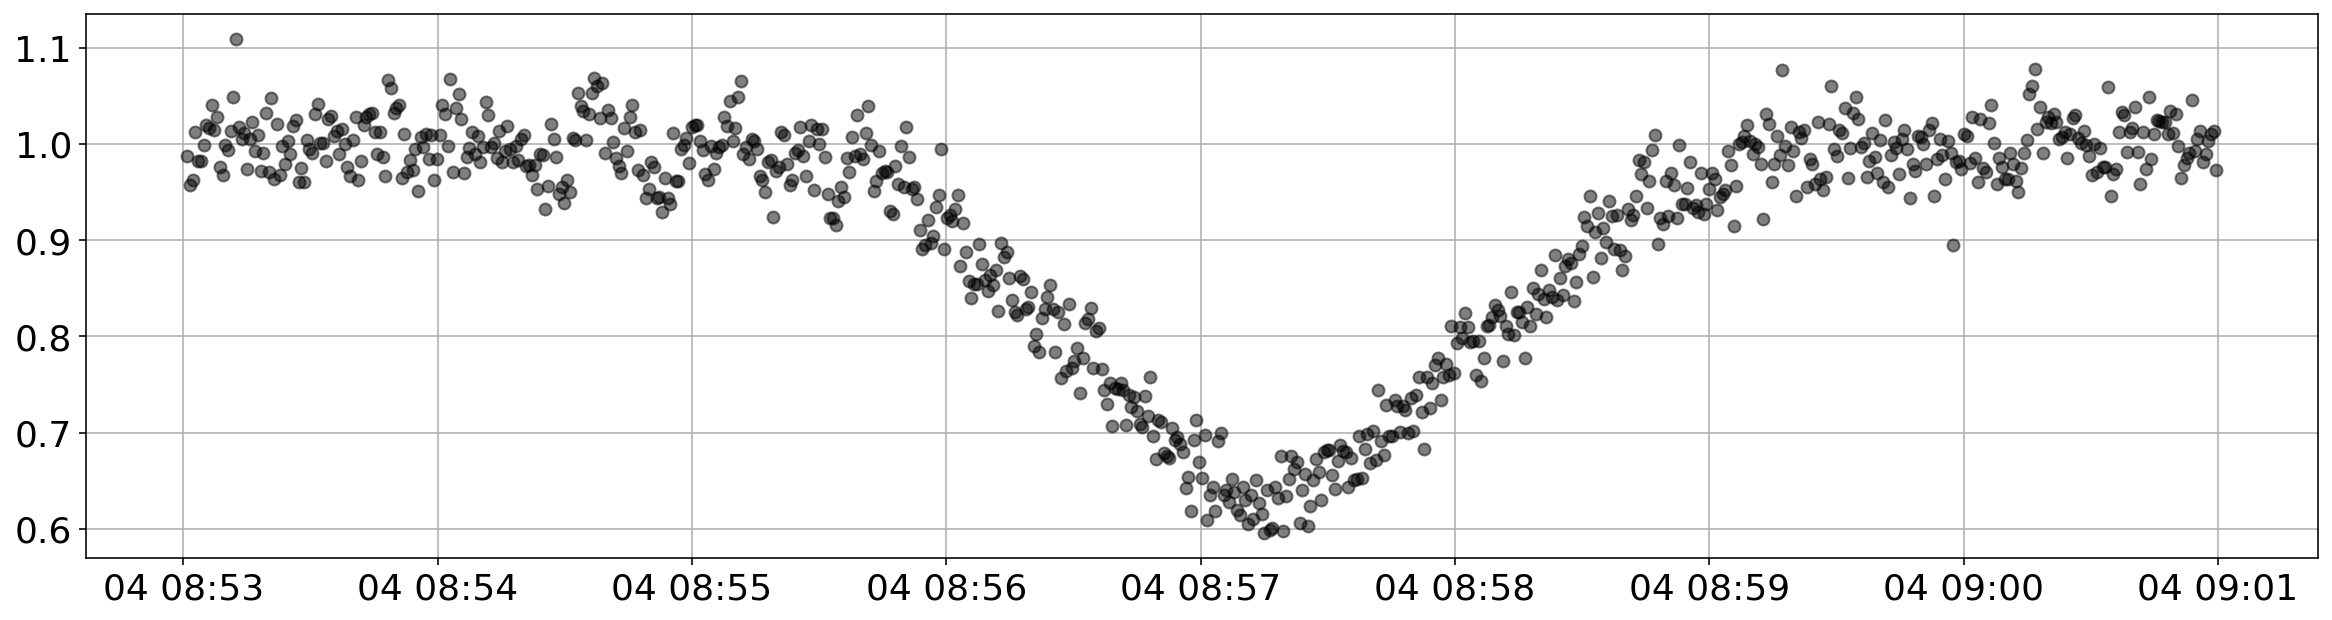

In [3]:
ts = lc_occ[0]

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(ts.time.datetime, ts['flux'], 'ko', alpha=0.5)
ax.grid()
ts.time.iso[0]

In [4]:
def get_satellite_positions(epochs):
    """
    Returns the positions of Gallilean satellites relative to Jupiter in (RA, DEC) space
    for the selected epochs.
    """
    jup = Horizons(id='599', epochs=epochs, id_type='id')
    io = Horizons(id='501', epochs=epochs, id_type='id')
    europa = Horizons(id='502', epochs=epochs, id_type='id')
    ganymede = Horizons(id='503', epochs=epochs, id_type='id')
    callisto = Horizons(id='504', epochs=epochs, id_type='id')

    # Compute positions of the satellites relative to Jupiter in (RA, DEC) space
    jup_pos = jup.ephemerides(quantities=1, extra_precision=True)
    io_pos = io.ephemerides(quantities=1, extra_precision=True)
    europa_pos = europa.ephemerides(quantities=1, extra_precision=True)
    ganymede_pos = ganymede.ephemerides(quantities=1, extra_precision=True)
    callisto_pos = callisto.ephemerides(quantities=1, extra_precision=True)
    
    timestamps = jup.ephemerides()['datetime_jd']
    
    io_rel_pos = QTable([io_pos['RA'] - jup_pos['RA'], 
                         io_pos['DEC'] - jup_pos['DEC']], 
                        names=['RA', 'DEC'])
    europa_rel_pos = QTable([europa_pos['RA'] - jup_pos['RA'], 
                             europa_pos['DEC'] - jup_pos['DEC']],
                            names=['RA', 'DEC'])
    ganymede_rel_pos = QTable([ganymede_pos['RA'] - jup_pos['RA'], 
                               ganymede_pos['DEC'] - jup_pos['DEC']],
                                names=['RA', 'DEC'])
    callisto_rel_pos = QTable([callisto_pos['RA'] - jup_pos['RA'],
                               callisto_pos['DEC'] - jup_pos['DEC']],
                                names=['RA', 'DEC'])
    
    io_rel_pos['RA'].unit = u.deg
    europa_rel_pos['RA'].unit = u.deg
    ganymede_rel_pos['RA'].unit = u.deg
    callisto_rel_pos['RA'].unit = u.deg

    io_rel_pos['DEC'].unit = u.deg
    europa_rel_pos['DEC'].unit = u.deg
    ganymede_rel_pos['DEC'].unit = u.deg
    callisto_rel_pos['DEC'].unit = u.deg
    
    return [timestamps, io_rel_pos, europa_rel_pos, ganymede_rel_pos, callisto_rel_pos]


def get_satellite_distances(epochs):
    """
    Returns distances of (Jupiter, Io, Europa, Ganymede, Callisto) w.r.t Earth for selected epochs. 
    """
    earth = Horizons(id='399', epochs=epochs, id_type='id')
    jup = Horizons(id='599', epochs=epochs, id_type='id')
    io = Horizons(id='501', epochs=epochs, id_type='id')
    europa = Horizons(id='502', epochs=epochs, id_type='id')
    ganymede = Horizons(id='503', epochs=epochs, id_type='id')
    callisto = Horizons(id='504', epochs=epochs, id_type='id')

    # Cartesian vectors
    earth_vec = earth.vectors()
    jup_vec = jup.vectors()
    io_vec = io.vectors()
    europa_vec = europa.vectors()
    ganymede_vec = ganymede.vectors()
    callisto_vec = callisto.vectors()
    
    def compute_distance(r1, r2):
        return np.sqrt((r2['x'] - r1['x'])**2 + (r2['y'] - r1['y'])**2 + (r2['z'] - r1['z'])**2)*u.au

    jup_distance = compute_distance(earth_vec, jup_vec)
    io_distance = compute_distance(earth_vec, io_vec)
    europa_distance = compute_distance(earth_vec, europa_vec)
    ganymede_distance = compute_distance(earth_vec, ganymede_vec)
    callisto_distance = compute_distance(earth_vec, callisto_vec)
    
    return [jup_distance, io_distance, europa_distance, ganymede_distance, callisto_distance]

# Observation times
epochs = {'start':'2009-12-04T08:53:00', 'stop':'2009-12-04T09:00:00',
                       'step':'1m'}

timestamps, pos_io, pos_europa, pos_ganymede, pos_callisto = get_satellite_positions(epochs)
dist_jup, dist_io, dist_europa, dist_ganymede, dist_callisto = get_satellite_distances(epochs)

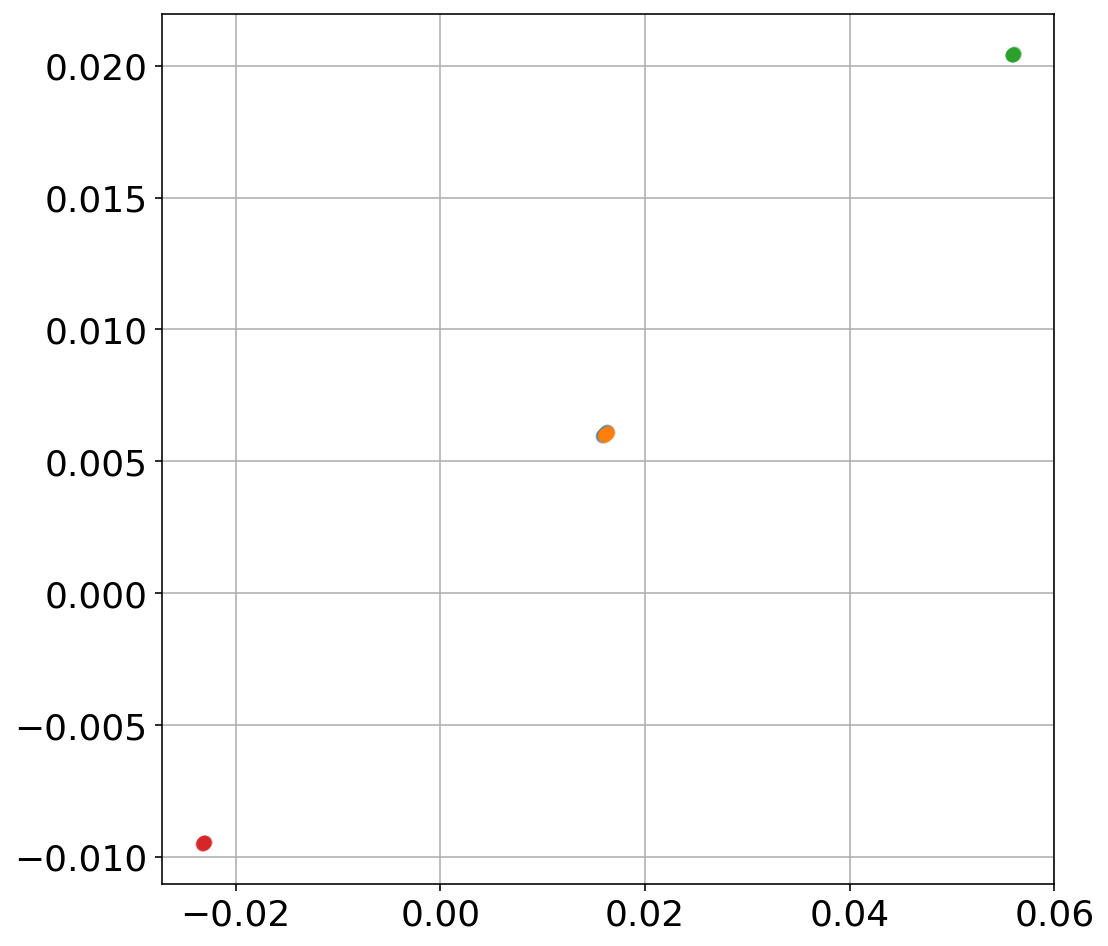

In [5]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(pos_io['RA'], pos_io['DEC'], 'C0o', alpha=0.5)
ax.plot(pos_europa['RA'], pos_europa['DEC'], 'C1o', alpha=0.5)
ax.plot(pos_ganymede['RA'], pos_ganymede['DEC'], 'C2o', alpha=0.5)
ax.plot(pos_callisto['RA'], pos_callisto['DEC'], 'C3o', alpha=0.5)

ax.grid()

'2009-12-04T08:56:00.000'

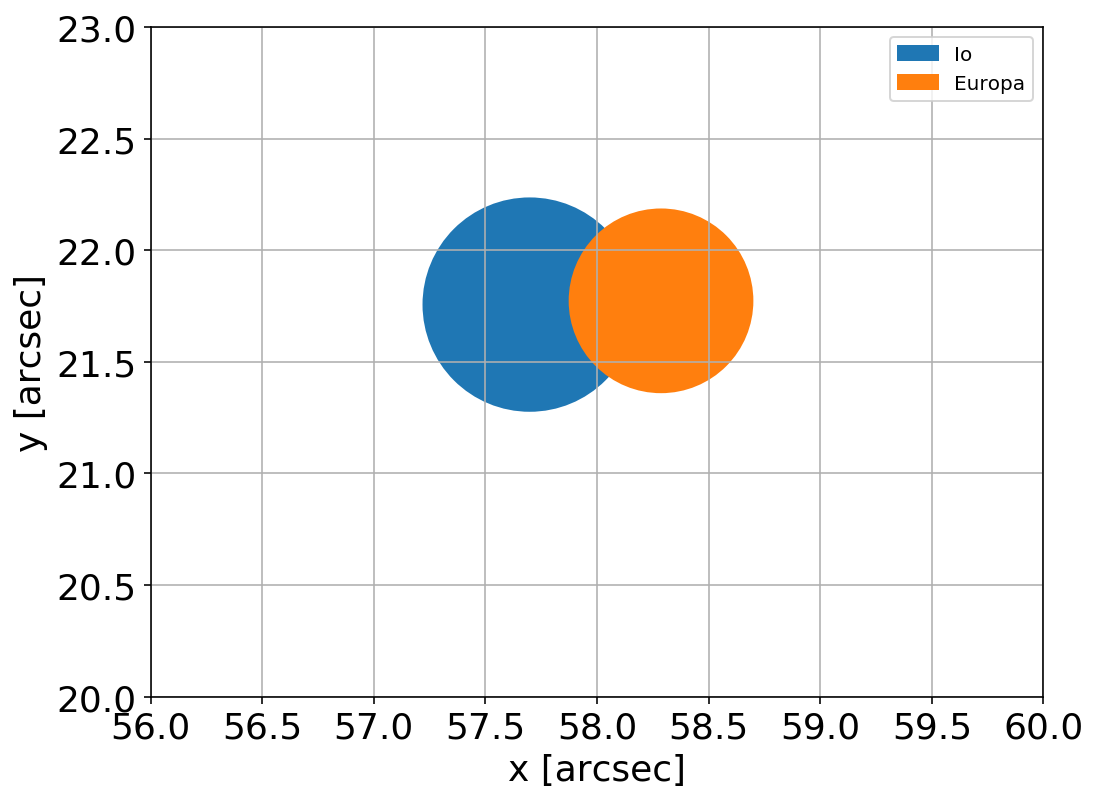

In [6]:
ang_radius_jup = (69911*u.km/dist_jup.to(u.km))*u.rad
ang_radius_io = (1821.3*u.km/dist_io.to(u.km))*u.rad
ang_radius_europa = (1565.*u.km/dist_europa.to(u.km))*u.rad
ang_radius_ganymede = (2634.*u.km/dist_ganymede.to(u.km))*u.rad
ang_radius_callisto = (2403.*u.km/dist_callisto.to(u.km))*u.rad

def plot_circles(ax, r1, r2, rad1, rad2):
    c1 = plt.Circle((r1[0], r1[1]), rad1, color='C0')
    c2 = plt.Circle((r2[0], r2[1]), rad2, color='C1')

    ax.add_artist(c1)
    ax.add_artist(c2)
    
    ax.legend([c1, c2], ['Io', 'Europa'])

    
fig, ax = plt.subplots(figsize=(8,8))  

idx = 3

plot_circles(ax, [pos_io['RA'][idx].to(u.arcsec).value, pos_io['DEC'][idx].to(u.arcsec).value],
              [pos_europa['RA'][idx].to(u.arcsec).value, pos_europa['DEC'][idx].to(u.arcsec).value],
          ang_radius_io[idx].to(u.arcsec).value, ang_radius_europa[idx].to(u.arcsec).value)

ax.set_ylim(20, 23)
ax.set_xlim(56, 60)
ax.set_aspect(1)
ax.grid()
ax.set_xlabel('x [arcsec]')
ax.set_ylabel('y [arcsec]')
Time(timestamps[idx], format='jd').isot

### Comparison to IMCCE multisat ephemeris

In [7]:
eph_jup = np.genfromtxt("imcce_calculator_jupiter.txt")
eph_io = np.genfromtxt("imcce_calculator_io.txt")
eph_europa = np.genfromtxt("imcce_calculator_europa.txt")

times = TimeSeries(time=Time(eph_jup[:, 0], format='mjd'))

ra_jup = eph_jup[:, 1]*360/24*u.deg
dec_jup = eph_jup[:, 2]*u.deg

ra_io = eph_io[:, 1]*360/24*u.deg
dec_io = eph_io[:, 2]*u.deg

ra_europa = eph_europa[:, 1]*360/24*u.deg
dec_europa = eph_europa[:, 2]*u.deg

ra_io_rel = ra_io - ra_jup
dec_io_rel = dec_io - dec_jup

ra_europa_rel = ra_europa - ra_jup
dec_europa_rel = dec_europa - dec_jup

Text(0.5, 1.0, 'Difference in ephemeris between JPL Horizons and IMCCE Multisat')

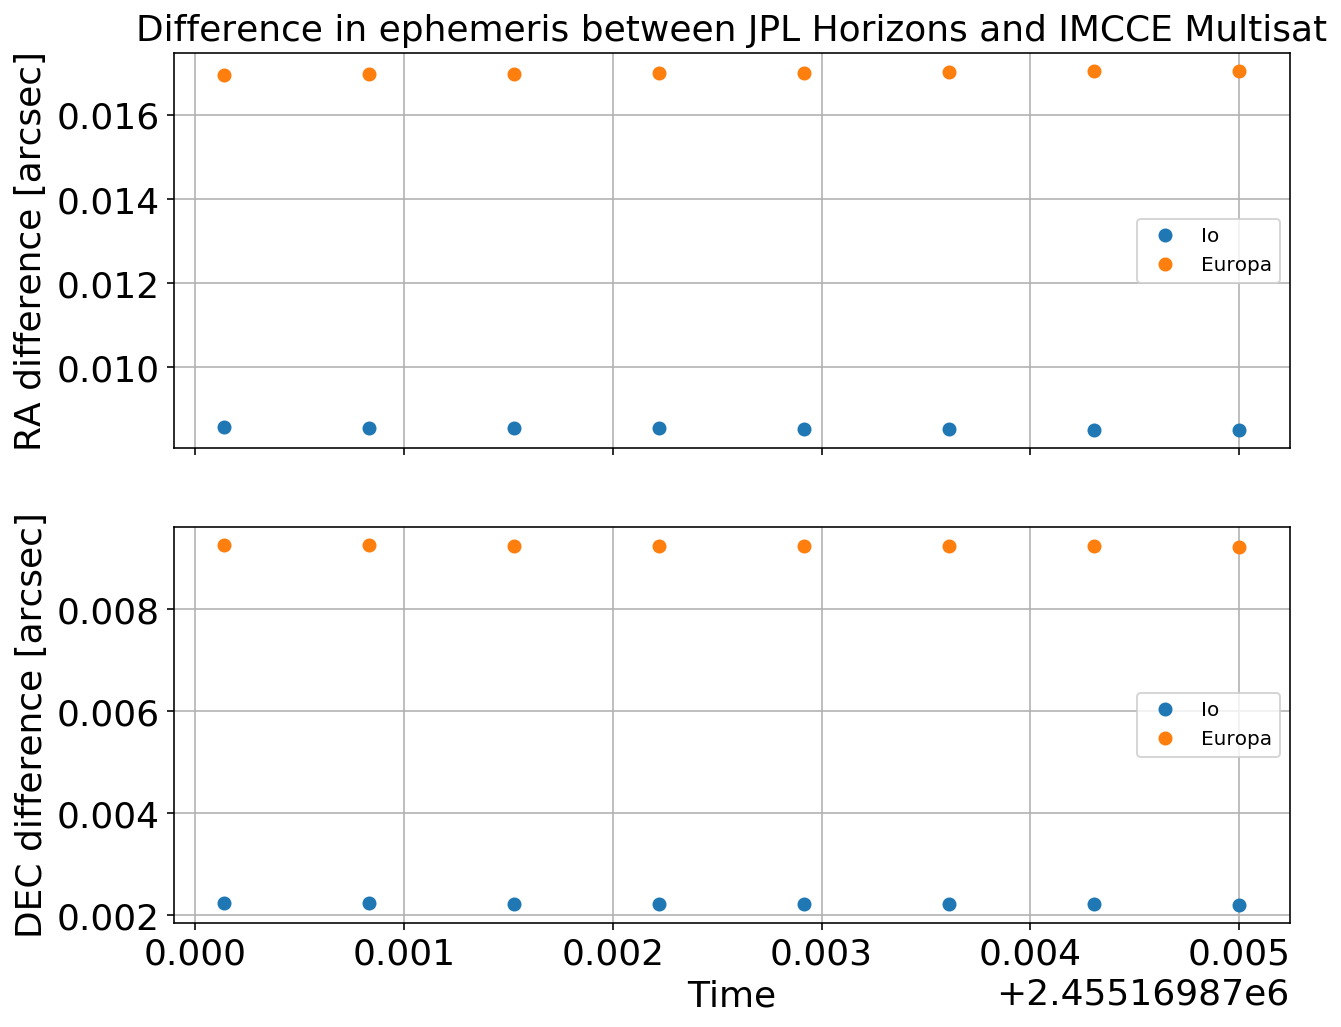

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax[0].plot(times.time.mjd, pos_io['RA'].to(u.arcsec).value - ra_io_rel.to(u.arcsec).value, 'C0o', label='Io')
ax[0].plot(times.time.mjd, pos_europa['RA'].to(u.arcsec).value - ra_europa_rel.to(u.arcsec).value, 'C1o', label='Europa')
ax[1].plot(times.time.mjd, pos_io['DEC'].to(u.arcsec).value - dec_io_rel.to(u.arcsec).value, 'C0o', label='Io')
ax[1].plot(times.time.mjd, pos_europa['DEC'].to(u.arcsec).value - dec_europa_rel.to(u.arcsec).value, 'C1o', label='Europa')


ax[0].set_ylabel("RA difference [arcsec]")
ax[1].set_ylabel("DEC difference [arcsec]")

ax[1].set_xlabel("Time")

for a in ax.flatten():
    a.grid()
    a.legend()


ax[0].set_title("Difference in ephemeris between JPL Horizons and IMCCE Multisat")